# Whatami

I am a simple experiment on using VIME with actor-critic agent setup for MountainCar problem.

Vime performance varies greatly depending on BNN.curiosity parameter so pls pay attention to it :)
* Large curiosity makes agent quickly learn to do weird things, some of which improve it's policy
* Low curiosity is close to vanilla a2c



## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


In [1]:
!wget https://raw.githubusercontent.com/justheuristic/vime/7e20be2231d680187dc79ad3e84b9658996d870c/bnn.py -O bnn.py
!wget https://raw.githubusercontent.com/justheuristic/vime/7e20be2231d680187dc79ad3e84b9658996d870c/curiosity.py -O curiosity.py

--2017-01-06 03:09:08--  https://raw.githubusercontent.com/justheuristic/vime/7e20be2231d680187dc79ad3e84b9658996d870c/bnn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... failed: Name or service not known.
wget: unable to resolve host address ‘raw.githubusercontent.com’
--2017-01-06 03:09:08--  https://raw.githubusercontent.com/justheuristic/vime/7e20be2231d680187dc79ad3e84b9658996d870c/curiosity.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... failed: Name or service not known.
wget: unable to resolve host address ‘raw.githubusercontent.com’


# Experiment setup
* Here we basically just load the game and check that it works

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS="floatX=float32"


env: THEANO_FLAGS="floatX=float32"


In [3]:
#global params.
GAME = "MountainCar-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

In [4]:
import gym
env = gym.make(GAME)
env.reset()

obs = env.step(0)[0]

action_names = np.array(["left",'stop',"right"]) #i guess so... i may be wrong
state_size = len(obs)

print(obs)

[2017-01-06 03:09:10,057] Making new env: MountainCar-v0


[-0.41774236 -0.00179341]


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [5]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,NonlinearityLayer,batch_norm,dropout
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,state_size))

dense0 = DenseLayer(observation_layer,100,name='dense1')
dense1 = DenseLayer(dense0,256,name='dense2')


In [6]:
#a layer that predicts Qvalues

policy_layer = DenseLayer(dense1,
                   num_units = env.action_space.n,
                   nonlinearity=lasagne.nonlinearities.softmax,
                   name="q-evaluator layer")


V_layer = DenseLayer(dense1, 1, nonlinearity=None,name="state values")

In [7]:


import theano
epsilon = theano.shared(np.float32(0),allow_downcast=True)
policy_smooth_layer = NonlinearityLayer(policy_layer,
                                        lambda p: (1.-epsilon)*p + epsilon/env.action_space.n)

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_smooth_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [8]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer,V_layer),
              action_layers=action_layer)


In [9]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer,V_layer),trainable=True)
weights

[dense1.W,
 dense1.b,
 dense2.W,
 dense2.b,
 q-evaluator layer.W,
 q-evaluator layer.b,
 state values.W,
 state values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [10]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=10000)


[2017-01-06 03:09:12,156] Making new env: MountainCar-v0


In [11]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['right' 'left' 'left' 'right' 'left' 'left' 'left']]
[[-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 10.4 ms


In [12]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# a2c loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [13]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [14]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import a2c_n_step

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = a2c_n_step.get_elementwise_objective(policy_seq,V_seq[:,:,0],
                                                       replay.actions[0],
                                                       replay.rewards,
                                                       replay.is_alive,
                                                       gamma_or_gammas=0.99,
                                                       n_steps=1)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [15]:
from theano import tensor as T
reg_entropy = T.mean((1./policy_seq))
loss += 0.01*reg_entropy

In [16]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss,weights,learning_rate=0.001)

In [17]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)


WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2017-01-06 03:10:01,125] We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


# Demo run

In [18]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=False)

[2017-01-06 03:10:25,406] Making new env: MountainCar-v0
[2017-01-06 03:10:25,420] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-06 03:10:25,424] Creating monitor directory ./records
[2017-01-06 03:10:25,592] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/Downloads/AgentNet/examples/records')


Episode finished after 200 timesteps with reward=-200.0


In [19]:
from IPython.display import HTML

#video_path="./records/openaigym.video.0.7346.video000000.mp4"

#HTML("""
#<video width="640" height="480" controls>
#  <source src="{}" type="video/mp4">
#</video>
#""".format(video_path))


# Vime

In [20]:
from bnn import bbpwrap, NormalApproximation,sample_output
from lasagne.layers import EmbeddingLayer
import theano.tensor as T
@bbpwrap(NormalApproximation())
class BayesDenseLayer(DenseLayer):pass
@bbpwrap(NormalApproximation())
class BayesEmbLayer(EmbeddingLayer):pass

from curiosity import compile_vime_reward

class BNN:
    curiosity=0.01
    target_rho = 1
    
    l_state = InputLayer((None,state_size),name='state var')
    l_action = InputLayer((None,),input_var=T.ivector())

    l_action_emb = BayesEmbLayer(l_action,env.action_space.n, 3)    
    
    l_concat = lasagne.layers.concat([l_action_emb,l_state])
    
    l_dense = BayesDenseLayer(l_concat,num_units=50,
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    l_out = BayesDenseLayer(l_dense,num_units=state_size,
                            nonlinearity=None)
        
    params = lasagne.layers.get_all_params(l_out,trainable=True)
    ###training###
    pred_states = lasagne.layers.get_output(l_out)
    next_states = T.matrix("next states")
    mse = lasagne.objectives.squared_error(pred_states,next_states).mean()
    
    #replace logposterior with simple regularization on rho cuz we're lazy
    reg = sum([lasagne.objectives.squared_error(rho,target_rho).mean() 
              for rho in lasagne.layers.get_all_params(l_out,rho=True)])
    
    loss = mse+ 0.01*reg
    
    updates = lasagne.updates.adam(loss,params)
    
    train_step = theano.function([l_state.input_var,l_action.input_var,next_states],
                                 loss,updates=updates)
    
    ###sample random sessions from pool###
    observations, = replay.observations
    actions, = replay.actions
    observations_flat = observations[:,:-1].reshape((-1,)+tuple(observations.shape[2:]))
    actions_flat = actions[:,:-1].reshape((-1,))
    next_observations_flat = observations[:,1:].reshape((-1,)+tuple(observations.shape[2:]))
    sample_from_pool = theano.function([],[observations_flat,actions_flat,next_observations_flat])

    
    ###curiosity reward### aka KL(qnew,qold)
    get_vime_reward_elwise = compile_vime_reward(l_out,l_state,l_action,params,n_samples=10)
    
    vime_reward_ma = 10.
    @staticmethod
    def add_vime_reward(observations,actions,rewards,is_alive,h0):
        assert isinstance(observations,np.ndarray)
        observations_flat = observations[:,:-1].reshape((-1,)+observations.shape[2:]).astype('float32')
        actions_flat = actions[:,:-1].reshape((-1,)).astype('int32')
        next_observations_flat = observations[:,1:].reshape((-1,)+observations.shape[2:]).astype('float32')

        vime_rewards = BNN.get_vime_reward_elwise(observations_flat,actions_flat,next_observations_flat)
        vime_rewards = np.concatenate([vime_rewards.reshape(rewards[:,:-1].shape),
                                       np.zeros_like(rewards[:,-1:]),], axis=1)
        #normalize by moving average
        BNN.vime_reward_ma = 0.99*BNN.vime_reward_ma + 0.01*vime_rewards.mean()
        
        surrogate_rewards = rewards + BNN.curiosity/BNN.vime_reward_ma*vime_rewards
        return (observations,actions,surrogate_rewards,is_alive,h0)
    
        


# Training loop

In [21]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [22]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,preprocess=BNN.add_vime_reward)

#pre-train BNN (mitigate training lag on first iterations where BNN is stupid)
for i in tqdm(range(1000)):
    BNN.train_step(*BNN.sample_from_pool())


100%|██████████| 1000/1000 [00:01<00:00, 710.10it/s]


In [23]:

#the loop may take eons to finish.
#consider interrupting early.
loss = 0
for i in tqdm(range(10000)):    
    
    
    #train
    for i in range(10):
        pool.update(SEQ_LENGTH,append=True,preprocess=BNN.add_vime_reward)

    for i in range(10):
        loss = loss*0.99 + train_step()*0.01
    
    for i in range(10):
        BNN.train_step(*BNN.sample_from_pool())

    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        pool_size = pool.experience_replay.rewards.get_value().shape[0]
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f\tpool_size=%i\tvime ma=%.5f"%(epoch_counter,
                                                         epsilon.get_value(),
                                                         pool_mean_reward,
                                                         pool_size,
                                                         BNN.vime_reward_ma))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        epsilon.set_value(0.05)
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 101/10000 [00:18<28:57,  5.70it/s]

iter=100	epsilon=0.000	reward/step=-0.98987	pool_size=2001	vime ma=1.49507


  2%|▏         | 201/10000 [00:36<28:51,  5.66it/s]

iter=200	epsilon=0.000	reward/step=-0.98961	pool_size=3001	vime ma=0.98446


  3%|▎         | 300/10000 [00:54<29:00,  5.57it/s]

iter=300	epsilon=0.000	reward/step=-0.98944	pool_size=4001	vime ma=0.69583


  4%|▍         | 401/10000 [01:12<28:48,  5.55it/s]

iter=400	epsilon=0.000	reward/step=-0.98930	pool_size=5001	vime ma=0.45956


  5%|▍         | 499/10000 [01:30<28:43,  5.51it/s][2016-12-19 20:40:38,939] Making new env: MountainCar-v0
[2016-12-19 20:40:38,943] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.000	reward/step=-0.98894	pool_size=6001	vime ma=0.33846


[2016-12-19 20:40:39,326] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
  5%|▌         | 501/10000 [01:31<41:39,  3.80it/s]

Current score(mean over 10) = -175.000


  6%|▌         | 601/10000 [01:49<28:42,  5.46it/s]

iter=600	epsilon=0.050	reward/step=-0.98860	pool_size=7001	vime ma=0.22617


  7%|▋         | 701/10000 [02:08<28:38,  5.41it/s]

iter=700	epsilon=0.050	reward/step=-0.98830	pool_size=8001	vime ma=0.15192


  8%|▊         | 801/10000 [02:26<28:00,  5.48it/s]

iter=800	epsilon=0.050	reward/step=-0.98805	pool_size=9001	vime ma=0.11583


  9%|▉         | 901/10000 [02:45<27:50,  5.45it/s]

iter=900	epsilon=0.050	reward/step=-0.98785	pool_size=10000	vime ma=0.08263


 10%|▉         | 999/10000 [03:03<27:28,  5.46it/s][2016-12-19 20:42:11,570] Making new env: MountainCar-v0
[2016-12-19 20:42:11,573] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.050	reward/step=-0.98746	pool_size=10000	vime ma=0.06162


[2016-12-19 20:42:11,864] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 10%|█         | 1001/10000 [03:03<36:51,  4.07it/s]

Current score(mean over 10) = -135.700


 11%|█         | 1101/10000 [03:22<27:17,  5.44it/s]

iter=1100	epsilon=0.050	reward/step=-0.98707	pool_size=10000	vime ma=0.04748


 12%|█▏        | 1201/10000 [03:41<27:04,  5.42it/s]

iter=1200	epsilon=0.050	reward/step=-0.98675	pool_size=10000	vime ma=0.03796


 13%|█▎        | 1301/10000 [03:59<26:39,  5.44it/s]

iter=1300	epsilon=0.050	reward/step=-0.98644	pool_size=10000	vime ma=0.02927


 14%|█▍        | 1401/10000 [04:18<26:20,  5.44it/s]

iter=1400	epsilon=0.050	reward/step=-0.98615	pool_size=10000	vime ma=0.02318


 15%|█▍        | 1499/10000 [04:36<26:18,  5.39it/s][2016-12-19 20:43:44,484] Making new env: MountainCar-v0
[2016-12-19 20:43:44,488] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.050	reward/step=-0.98602	pool_size=10000	vime ma=0.01951


[2016-12-19 20:43:44,795] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 15%|█▌        | 1501/10000 [04:36<35:26,  4.00it/s]

Current score(mean over 10) = -145.200


 16%|█▌        | 1601/10000 [04:55<25:32,  5.48it/s]

iter=1600	epsilon=0.050	reward/step=-0.98596	pool_size=10000	vime ma=0.01643


 17%|█▋        | 1701/10000 [05:13<25:20,  5.46it/s]

iter=1700	epsilon=0.050	reward/step=-0.98592	pool_size=10000	vime ma=0.01466


 18%|█▊        | 1801/10000 [05:32<25:24,  5.38it/s]

iter=1800	epsilon=0.050	reward/step=-0.98592	pool_size=10000	vime ma=0.01379


 19%|█▉        | 1901/10000 [05:50<24:50,  5.44it/s]

iter=1900	epsilon=0.050	reward/step=-0.98589	pool_size=10000	vime ma=0.01276


 20%|█▉        | 1999/10000 [06:08<24:42,  5.40it/s][2016-12-19 20:45:17,039] Making new env: MountainCar-v0
[2016-12-19 20:45:17,042] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=-0.98588	pool_size=10000	vime ma=0.01282


[2016-12-19 20:45:17,337] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 20%|██        | 2001/10000 [06:09<32:56,  4.05it/s]

Current score(mean over 10) = -137.900


 21%|██        | 2101/10000 [06:27<24:19,  5.41it/s]

iter=2100	epsilon=0.050	reward/step=-0.98585	pool_size=10000	vime ma=0.01401


 22%|██▏       | 2201/10000 [06:46<23:58,  5.42it/s]

iter=2200	epsilon=0.050	reward/step=-0.98583	pool_size=10000	vime ma=0.01397


 23%|██▎       | 2301/10000 [07:05<23:46,  5.40it/s]

iter=2300	epsilon=0.050	reward/step=-0.98578	pool_size=10000	vime ma=0.01484


 24%|██▍       | 2401/10000 [07:23<23:30,  5.39it/s]

iter=2400	epsilon=0.050	reward/step=-0.98577	pool_size=10000	vime ma=0.01543


 25%|██▍       | 2499/10000 [07:41<23:10,  5.40it/s][2016-12-19 20:46:50,146] Making new env: MountainCar-v0
[2016-12-19 20:46:50,149] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2500	epsilon=0.050	reward/step=-0.98573	pool_size=10000	vime ma=0.01644


[2016-12-19 20:46:50,466] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 25%|██▌       | 2501/10000 [07:42<31:28,  3.97it/s]

Current score(mean over 10) = -147.800


 26%|██▌       | 2601/10000 [08:00<22:01,  5.60it/s]

iter=2600	epsilon=0.050	reward/step=-0.98570	pool_size=10000	vime ma=0.01800


 27%|██▋       | 2701/10000 [08:20<22:18,  5.45it/s]

iter=2700	epsilon=0.050	reward/step=-0.98567	pool_size=10000	vime ma=0.01884


 28%|██▊       | 2801/10000 [08:39<22:08,  5.42it/s]

iter=2800	epsilon=0.050	reward/step=-0.98563	pool_size=10000	vime ma=0.02053


 29%|██▉       | 2901/10000 [08:57<21:53,  5.41it/s]

iter=2900	epsilon=0.050	reward/step=-0.98559	pool_size=10000	vime ma=0.02125


 30%|██▉       | 2999/10000 [09:16<21:28,  5.43it/s][2016-12-19 20:48:24,581] Making new env: MountainCar-v0
[2016-12-19 20:48:24,584] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3000	epsilon=0.050	reward/step=-0.98558	pool_size=10000	vime ma=0.02315


[2016-12-19 20:48:24,876] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 30%|███       | 3001/10000 [09:16<28:52,  4.04it/s]

Current score(mean over 10) = -138.800


 31%|███       | 3101/10000 [09:35<21:11,  5.42it/s]

iter=3100	epsilon=0.050	reward/step=-0.98556	pool_size=10000	vime ma=0.02464


 32%|███▏      | 3201/10000 [09:53<20:55,  5.42it/s]

iter=3200	epsilon=0.050	reward/step=-0.98555	pool_size=10000	vime ma=0.02558


 33%|███▎      | 3301/10000 [10:12<19:54,  5.61it/s]

iter=3300	epsilon=0.050	reward/step=-0.98555	pool_size=10000	vime ma=0.02658


 34%|███▍      | 3401/10000 [10:31<18:57,  5.80it/s]

iter=3400	epsilon=0.050	reward/step=-0.98554	pool_size=10000	vime ma=0.02823


 35%|███▍      | 3499/10000 [10:48<18:30,  5.86it/s][2016-12-19 20:49:56,888] Making new env: MountainCar-v0
[2016-12-19 20:49:56,891] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3500	epsilon=0.050	reward/step=-0.98556	pool_size=10000	vime ma=0.03107


[2016-12-19 20:49:57,137] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 35%|███▌      | 3501/10000 [10:49<24:13,  4.47it/s]

Current score(mean over 10) = -122.800


 36%|███▌      | 3601/10000 [11:06<18:15,  5.84it/s]

iter=3600	epsilon=0.050	reward/step=-0.98553	pool_size=10000	vime ma=0.03301


 37%|███▋      | 3701/10000 [11:23<17:57,  5.84it/s]

iter=3700	epsilon=0.050	reward/step=-0.98551	pool_size=10000	vime ma=0.03348


 38%|███▊      | 3801/10000 [11:40<17:43,  5.83it/s]

iter=3800	epsilon=0.050	reward/step=-0.98549	pool_size=10000	vime ma=0.03590


 39%|███▉      | 3901/10000 [11:57<17:59,  5.65it/s]

iter=3900	epsilon=0.050	reward/step=-0.98548	pool_size=10000	vime ma=0.03589


 40%|███▉      | 3999/10000 [12:15<17:12,  5.81it/s][2016-12-19 20:51:24,148] Making new env: MountainCar-v0
[2016-12-19 20:51:24,151] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4000	epsilon=0.050	reward/step=-0.98545	pool_size=10000	vime ma=0.03756


[2016-12-19 20:51:24,534] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 40%|████      | 4000/10000 [12:16<28:59,  3.45it/s]

Current score(mean over 10) = -124.800


 41%|████      | 4101/10000 [12:34<17:28,  5.63it/s]

iter=4100	epsilon=0.050	reward/step=-0.98544	pool_size=10000	vime ma=0.03999


 42%|████▏     | 4201/10000 [12:52<17:06,  5.65it/s]

iter=4200	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.04276


 43%|████▎     | 4301/10000 [13:09<16:53,  5.62it/s]

iter=4300	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.04631


 44%|████▍     | 4401/10000 [13:27<16:22,  5.70it/s]

iter=4400	epsilon=0.050	reward/step=-0.98542	pool_size=10000	vime ma=0.04630


 45%|████▍     | 4499/10000 [13:44<16:08,  5.68it/s][2016-12-19 20:52:53,263] Making new env: MountainCar-v0
[2016-12-19 20:52:53,266] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4500	epsilon=0.050	reward/step=-0.98541	pool_size=10000	vime ma=0.04686


[2016-12-19 20:52:53,516] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 45%|████▌     | 4501/10000 [13:45<21:15,  4.31it/s]

Current score(mean over 10) = -116.800


 46%|████▌     | 4601/10000 [14:03<15:45,  5.71it/s]

iter=4600	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.04803


 47%|████▋     | 4701/10000 [14:20<15:21,  5.75it/s]

iter=4700	epsilon=0.050	reward/step=-0.98542	pool_size=10000	vime ma=0.05137


 48%|████▊     | 4801/10000 [14:38<15:02,  5.76it/s]

iter=4800	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.05336


 49%|████▉     | 4901/10000 [14:55<15:02,  5.65it/s]

iter=4900	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.05540


 50%|████▉     | 4999/10000 [15:12<14:40,  5.68it/s][2016-12-19 20:54:21,191] Making new env: MountainCar-v0
[2016-12-19 20:54:21,195] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5000	epsilon=0.050	reward/step=-0.98544	pool_size=10000	vime ma=0.05811


[2016-12-19 20:54:21,455] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 50%|█████     | 5001/10000 [15:13<19:23,  4.30it/s]

Current score(mean over 10) = -126.900


 51%|█████     | 5101/10000 [15:30<14:02,  5.81it/s]

iter=5100	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.05938


 52%|█████▏    | 5201/10000 [15:48<14:02,  5.69it/s]

iter=5200	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.06224


 53%|█████▎    | 5301/10000 [16:06<13:40,  5.73it/s]

iter=5300	epsilon=0.050	reward/step=-0.98542	pool_size=10000	vime ma=0.06232


 54%|█████▍    | 5401/10000 [16:23<13:27,  5.70it/s]

iter=5400	epsilon=0.050	reward/step=-0.98542	pool_size=10000	vime ma=0.06291


 55%|█████▍    | 5499/10000 [16:41<13:15,  5.66it/s][2016-12-19 20:55:49,383] Making new env: MountainCar-v0
[2016-12-19 20:55:49,386] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5500	epsilon=0.050	reward/step=-0.98540	pool_size=10000	vime ma=0.06636


[2016-12-19 20:55:49,652] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 55%|█████▌    | 5501/10000 [16:41<17:27,  4.29it/s]

Current score(mean over 10) = -129.300


 56%|█████▌    | 5601/10000 [16:59<12:37,  5.81it/s]

iter=5600	epsilon=0.050	reward/step=-0.98540	pool_size=10000	vime ma=0.06592


 57%|█████▋    | 5701/10000 [17:16<12:17,  5.83it/s]

iter=5700	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.06968


 58%|█████▊    | 5801/10000 [17:33<12:01,  5.82it/s]

iter=5800	epsilon=0.050	reward/step=-0.98544	pool_size=10000	vime ma=0.07336


 59%|█████▉    | 5901/10000 [17:50<11:49,  5.78it/s]

iter=5900	epsilon=0.050	reward/step=-0.98545	pool_size=10000	vime ma=0.07236


 60%|█████▉    | 5999/10000 [18:07<11:29,  5.80it/s][2016-12-19 20:57:15,937] Making new env: MountainCar-v0
[2016-12-19 20:57:15,940] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6000	epsilon=0.050	reward/step=-0.98544	pool_size=10000	vime ma=0.07627


[2016-12-19 20:57:16,208] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 60%|██████    | 6001/10000 [18:08<15:24,  4.33it/s]

Current score(mean over 10) = -130.500


 61%|██████    | 6101/10000 [18:25<11:18,  5.74it/s]

iter=6100	epsilon=0.050	reward/step=-0.98547	pool_size=10000	vime ma=0.08218


 62%|██████▏   | 6201/10000 [18:42<10:49,  5.85it/s]

iter=6200	epsilon=0.050	reward/step=-0.98546	pool_size=10000	vime ma=0.08128


 63%|██████▎   | 6301/10000 [19:00<10:44,  5.74it/s]

iter=6300	epsilon=0.050	reward/step=-0.98548	pool_size=10000	vime ma=0.08074


 64%|██████▍   | 6401/10000 [19:17<10:05,  5.94it/s]

iter=6400	epsilon=0.050	reward/step=-0.98548	pool_size=10000	vime ma=0.08309


 65%|██████▍   | 6499/10000 [19:34<10:02,  5.81it/s][2016-12-19 20:58:42,401] Making new env: MountainCar-v0
[2016-12-19 20:58:42,404] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6500	epsilon=0.050	reward/step=-0.98549	pool_size=10000	vime ma=0.08857


[2016-12-19 20:58:42,676] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 65%|██████▌   | 6501/10000 [19:34<13:28,  4.33it/s]

Current score(mean over 10) = -137.600


 66%|██████▌   | 6601/10000 [19:51<09:29,  5.96it/s]

iter=6600	epsilon=0.050	reward/step=-0.98547	pool_size=10000	vime ma=0.08450


 67%|██████▋   | 6701/10000 [20:08<09:39,  5.70it/s]

iter=6700	epsilon=0.050	reward/step=-0.98545	pool_size=10000	vime ma=0.08786


 68%|██████▊   | 6801/10000 [20:26<08:58,  5.94it/s]

iter=6800	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.09014


 69%|██████▉   | 6901/10000 [20:43<08:41,  5.95it/s]

iter=6900	epsilon=0.050	reward/step=-0.98542	pool_size=10000	vime ma=0.09215


 70%|██████▉   | 6999/10000 [21:00<08:21,  5.98it/s][2016-12-19 21:00:08,960] Making new env: MountainCar-v0
[2016-12-19 21:00:08,963] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7000	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.09571


[2016-12-19 21:00:09,231] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 70%|███████   | 7001/10000 [21:01<11:14,  4.45it/s]

Current score(mean over 10) = -136.400


 71%|███████   | 7101/10000 [21:18<08:12,  5.89it/s]

iter=7100	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.09054


 72%|███████▏  | 7201/10000 [21:35<08:07,  5.74it/s]

iter=7200	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.10057


 73%|███████▎  | 7301/10000 [21:52<07:39,  5.87it/s]

iter=7300	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.10179


 74%|███████▍  | 7401/10000 [22:09<07:30,  5.77it/s]

iter=7400	epsilon=0.050	reward/step=-0.98545	pool_size=10000	vime ma=0.09719


 75%|███████▍  | 7499/10000 [22:26<07:05,  5.88it/s][2016-12-19 21:01:34,885] Making new env: MountainCar-v0
[2016-12-19 21:01:34,889] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7500	epsilon=0.050	reward/step=-0.98545	pool_size=10000	vime ma=0.10807


[2016-12-19 21:01:35,118] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 75%|███████▌  | 7501/10000 [22:27<09:06,  4.57it/s]

Current score(mean over 10) = -113.900


 76%|███████▌  | 7601/10000 [22:44<06:42,  5.96it/s]

iter=7600	epsilon=0.050	reward/step=-0.98547	pool_size=10000	vime ma=0.10622


 77%|███████▋  | 7701/10000 [23:01<06:30,  5.89it/s]

iter=7700	epsilon=0.050	reward/step=-0.98548	pool_size=10000	vime ma=0.10591


 78%|███████▊  | 7801/10000 [23:18<06:14,  5.87it/s]

iter=7800	epsilon=0.050	reward/step=-0.98550	pool_size=10000	vime ma=0.10040


 79%|███████▉  | 7901/10000 [23:34<05:51,  5.98it/s]

iter=7900	epsilon=0.050	reward/step=-0.98551	pool_size=10000	vime ma=0.10582


 80%|███████▉  | 7999/10000 [23:51<05:32,  6.01it/s][2016-12-19 21:03:00,036] Making new env: MountainCar-v0
[2016-12-19 21:03:00,039] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8000	epsilon=0.050	reward/step=-0.98552	pool_size=10000	vime ma=0.10580


[2016-12-19 21:03:00,266] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 80%|████████  | 8001/10000 [23:52<07:12,  4.62it/s]

Current score(mean over 10) = -119.300


 81%|████████  | 8101/10000 [24:09<05:31,  5.72it/s]

iter=8100	epsilon=0.050	reward/step=-0.98548	pool_size=10000	vime ma=0.11122


 82%|████████▏ | 8201/10000 [24:26<05:08,  5.83it/s]

iter=8200	epsilon=0.050	reward/step=-0.98548	pool_size=10000	vime ma=0.11433


 83%|████████▎ | 8301/10000 [24:42<04:43,  5.99it/s]

iter=8300	epsilon=0.050	reward/step=-0.98547	pool_size=10000	vime ma=0.11995


 84%|████████▍ | 8401/10000 [24:59<04:27,  5.98it/s]

iter=8400	epsilon=0.050	reward/step=-0.98544	pool_size=10000	vime ma=0.11373


 85%|████████▍ | 8499/10000 [25:16<04:13,  5.93it/s][2016-12-19 21:04:24,473] Making new env: MountainCar-v0
[2016-12-19 21:04:24,477] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8500	epsilon=0.050	reward/step=-0.98545	pool_size=10000	vime ma=0.12114


[2016-12-19 21:04:24,720] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 85%|████████▌ | 8501/10000 [25:16<05:30,  4.54it/s]

Current score(mean over 10) = -123.700


 86%|████████▌ | 8601/10000 [25:33<03:53,  5.99it/s]

iter=8600	epsilon=0.050	reward/step=-0.98546	pool_size=10000	vime ma=0.11504


 87%|████████▋ | 8701/10000 [25:50<03:38,  5.93it/s]

iter=8700	epsilon=0.050	reward/step=-0.98544	pool_size=10000	vime ma=0.12073


 88%|████████▊ | 8801/10000 [26:07<03:21,  5.94it/s]

iter=8800	epsilon=0.050	reward/step=-0.98542	pool_size=10000	vime ma=0.12067


 89%|████████▉ | 8901/10000 [26:24<03:05,  5.92it/s]

iter=8900	epsilon=0.050	reward/step=-0.98542	pool_size=10000	vime ma=0.11832


 90%|████████▉ | 8999/10000 [26:40<02:48,  5.92it/s][2016-12-19 21:05:49,171] Making new env: MountainCar-v0
[2016-12-19 21:05:49,174] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9000	epsilon=0.050	reward/step=-0.98541	pool_size=10000	vime ma=0.12431


[2016-12-19 21:05:49,401] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 90%|█████████ | 9001/10000 [26:41<03:36,  4.62it/s]

Current score(mean over 10) = -115.500


 91%|█████████ | 9101/10000 [26:58<02:29,  6.01it/s]

iter=9100	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.12388


 92%|█████████▏| 9201/10000 [27:14<02:13,  5.99it/s]

iter=9200	epsilon=0.050	reward/step=-0.98544	pool_size=10000	vime ma=0.12059


 93%|█████████▎| 9301/10000 [27:31<01:57,  5.93it/s]

iter=9300	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.13206


 94%|█████████▍| 9401/10000 [27:48<01:38,  6.05it/s]

iter=9400	epsilon=0.050	reward/step=-0.98545	pool_size=10000	vime ma=0.12722


 95%|█████████▍| 9499/10000 [28:04<01:25,  5.89it/s][2016-12-19 21:07:13,200] Making new env: MountainCar-v0
[2016-12-19 21:07:13,203] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9500	epsilon=0.050	reward/step=-0.98545	pool_size=10000	vime ma=0.12840


[2016-12-19 21:07:13,458] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
 95%|█████████▌| 9501/10000 [28:05<01:51,  4.47it/s]

Current score(mean over 10) = -131.000


 96%|█████████▌| 9601/10000 [28:22<01:07,  5.95it/s]

iter=9600	epsilon=0.050	reward/step=-0.98543	pool_size=10000	vime ma=0.12904


 97%|█████████▋| 9701/10000 [28:39<00:50,  5.97it/s]

iter=9700	epsilon=0.050	reward/step=-0.98544	pool_size=10000	vime ma=0.12571


 98%|█████████▊| 9801/10000 [28:55<00:34,  5.81it/s]

iter=9800	epsilon=0.050	reward/step=-0.98546	pool_size=10000	vime ma=0.13549


 99%|█████████▉| 9901/10000 [29:12<00:16,  5.96it/s]

iter=9900	epsilon=0.050	reward/step=-0.98547	pool_size=10000	vime ma=0.13109


100%|█████████▉| 9999/10000 [29:29<00:00,  5.93it/s][2016-12-19 21:08:37,379] Making new env: MountainCar-v0
[2016-12-19 21:08:37,382] Clearing 2 monitor files from previous run (because force=True was provided)


iter=10000	epsilon=0.050	reward/step=-0.98547	pool_size=10000	vime ma=0.13753


[2016-12-19 21:08:37,632] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/vime/records')
100%|██████████| 10000/10000 [29:29<00:00,  4.09it/s]

Current score(mean over 10) = -128.600


In [24]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda (k,v):k))

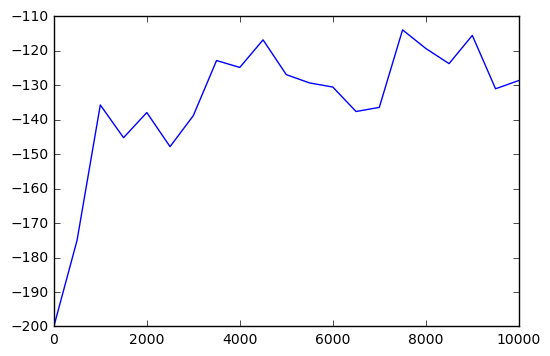

In [25]:
plt.plot(iters,map(np.mean,session_rewards))

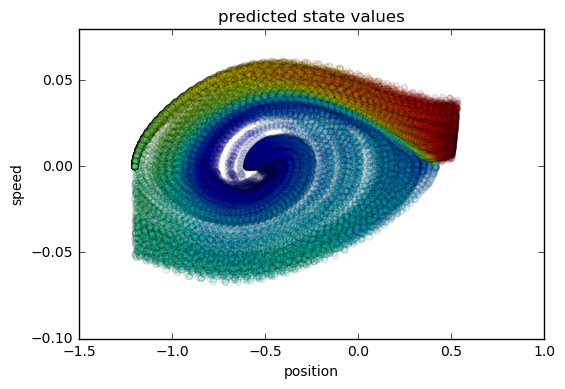

In [26]:

_,_,_,_,(pool_policy,pool_V) = agent.get_sessions(
    pool.experience_replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,)

plt.scatter(
    *pool.experience_replay.observations[0].get_value().reshape([-1,2]).T,
    c = pool_V.ravel().eval(),
    alpha = 0.1)
plt.title("predicted state values")
plt.xlabel("position")
plt.ylabel("speed")

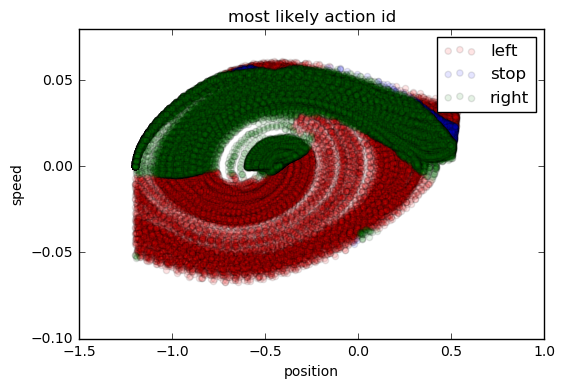

In [27]:
obs_x,obs_y = pool.experience_replay.observations[0].get_value().reshape([-1,2]).T
optimal_actid = pool_policy.argmax(-1).ravel().eval()

for i in range(3):
    sel = optimal_actid==i
    plt.scatter(obs_x[sel],obs_y[sel],
                c=['red','blue','green'][i],
                alpha = 0.1,label=action_names[i])
    
plt.title("most likely action id")
plt.xlabel("position")
plt.ylabel("speed")
plt.legend(loc='best')